In [ ]:
import os, sys
project_root_dir = os.path.join(os.getcwd(),'../..')
if project_root_dir not in sys.path:
    sys.path.append(project_root_dir)

from matplotlib import pyplot as plt
import numpy as np
from torch import nn
import torch
import config

from utils import show_abundance, plot_endmembers
# from dataset import JasperRidgeDataset
from HySpecLab.metrics import rmse, sad
from scipy import io as sio

In [ ]:
from dataset import JasperRidge

dataset = JasperRidge(config.JasperRidge_PATH)
dataset_name = 'JasperRidge'
wv = np.array(dataset.wv, dtype=np.uint)

result_path = os.path.join(config.RESULTS_PATH, 'jasperRidge')

# Ground Truth

In [ ]:
from utils import plot_endmembers, show_abundance
fig = plot_endmembers(dataset.endmembers(), wv, ticks_range=(0, 1), n_ticks=5)
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/A_ref.png'), dpi=300, bbox_inches='tight')

In [ ]:
from HySpecLab.metrics import sad

def sort_endmember(endmembers, gt):
    sad_result = sad(endmembers, gt)
    e_idx = torch.argmin(sad_result, dim=0) # Index for reordering the ground truth
    return e_idx, sad_result

In [ ]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=-1, random_state=25)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, wv, ticks_range=(0, 1))
plt.show(fig)

# fig.savefig(os.path.join(result_path, 'imgs/M_vca.pdf'), bbox_inches='tight')

In [ ]:
from utils import plot_endmembers
from pysptools import eea
n_endmembers = dataset.n_endmembers

ee = eea.NFINDR()
endmember = torch.from_numpy(ee.extract(dataset.image(), n_endmembers)).float()

e_idx, _ = sort_endmember(endmember, dataset.endmembers())
nfindr_endmember_init = endmember[e_idx]
nfindr_logit_endmember_init = torch.log((nfindr_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(nfindr_endmember_init, wv, ticks_range=(0, 1))
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_nfindr.pdf'), bbox_inches='tight')

In [ ]:
fig = plot_endmembers(dataset.endmembers() / dataset.endmembers().max(), wv, ticks_range=(0, 1), endmember_estimation=[nfindr_endmember_init, vca_endmember_init], ee_labels=['Ground Truth', 'N-FINDR', 'VCA'])
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_estimation.pdf'), bbox_inches='tight')

In [ ]:
# endmember_init_method = 'nfindr'
# endmember_init = nfindr_endmember_init
# logit_endmember_init = nfindr_logit_endmember_init

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

In [ ]:
param_grid = {
    'sigma_sparsity': [.05, .1, .25, .5],
    'sparse_weight': [0, .05, .1, .25, .5, 1],
}

In [ ]:
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk) 
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m

In [ ]:
from sklearn.model_selection import ParameterGrid
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing
import pandas as pd
from tqdm import tqdm

n_bands = dataset.n_bands
results = pd.DataFrame(columns=['sigma_sparsity', 'sparse_weight', 'mean_rmse_x', 'mean_rmse_a', 'mean_sad_m'])
for params in ParameterGrid(param_grid):
    sigma = params['sigma_sparsity']
    sparse_weight = params['sparse_weight']
    batch_rmse_x, batch_rmse_a, batch_sad_m = [], [], []

    for i in tqdm(range(5)):
        model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sigma_sparsity=sigma)
        train(model, n_endmembers, dataset, n_batchs=50, n_epochs=100, lr=1e-3, similarity_weight=1, sparse_weight=sparse_weight)
        rmse_x, rmse_a, sad_m = test(model, dataset)
        batch_rmse_x.append(rmse_x)
        batch_rmse_a.append(rmse_a)
        batch_sad_m.append(sad_m)

    mean_rmse_x = sum(batch_rmse_x) / len(batch_rmse_x)
    mean_rmse_a = sum(batch_rmse_a) / len(batch_rmse_a)
    mean_sad_m = sum(batch_sad_m) / len(batch_sad_m)
    
    results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)

In [ ]:
csv_save_path = os.path.join(result_path, 'hyperparameters.csv')
results.to_csv(csv_save_path, index=False)

# Apex

In [ ]:
from dataset import Apex
dataset = Apex(config.Apex_PATH)

result_path = os.path.join(config.RESULTS_PATH, 'apex')

In [ ]:

fig = plot_endmembers(dataset.endmembers(), np.array(dataset.wv), ticks_range=(0, .5), n_ticks=5)
plt.show(fig)
# fig.savefig(os.path.join(result_path, 'imgs/M_ref.pdf'), bbox_inches='tight')

fig = show_abundance(dataset.abundance())
plt.show(fig)


In [ ]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=20, random_state=42)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, dataset.wv, ticks_range=(0, 1))
plt.show(fig)

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

In [ ]:
from sklearn.model_selection import ParameterGrid
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing
import pandas as pd
from tqdm import tqdm

n_bands = dataset.n_bands
results = pd.DataFrame(columns=['sigma_sparsity', 'sparse_weight', 'mean_rmse_x', 'mean_rmse_a', 'mean_sad_m'])
for params in ParameterGrid(param_grid):
    sigma = params['sigma_sparsity']
    sparse_weight = params['sparse_weight']
    print('Sigma:', sigma, 'Sparse Weight:', sparse_weight)
    batch_rmse_x, batch_rmse_a, batch_sad_m = [], [], []

    for i in tqdm(range(5)):
        model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sigma_sparsity=sigma)
        train(model, n_endmembers, dataset, n_batchs=50, n_epochs=100, lr=1e-3, similarity_weight=1, sparse_weight=sparse_weight)
        rmse_x, rmse_a, sad_m = test(model, dataset)
        batch_rmse_x.append(rmse_x)
        batch_rmse_a.append(rmse_a)
        batch_sad_m.append(sad_m)

    mean_rmse_x = sum(batch_rmse_x) / len(batch_rmse_x)
    mean_rmse_a = sum(batch_rmse_a) / len(batch_rmse_a)
    mean_sad_m = sum(batch_sad_m) / len(batch_sad_m)
    
    results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)
    print('Mean RMSE X:', mean_rmse_x, 'Mean RMSE A:', mean_rmse_a, 'Mean SAD M:', mean_sad_m)

In [ ]:
results

In [ ]:
csv_save_path = os.path.join(result_path, 'hyperparameters.csv')
results.to_csv(csv_save_path, index=False)

# Samson

In [ ]:
from dataset import Samson

dataset = Samson(config.Samson_PATH)
result_path = os.path.join(config.RESULTS_PATH, 'samson')

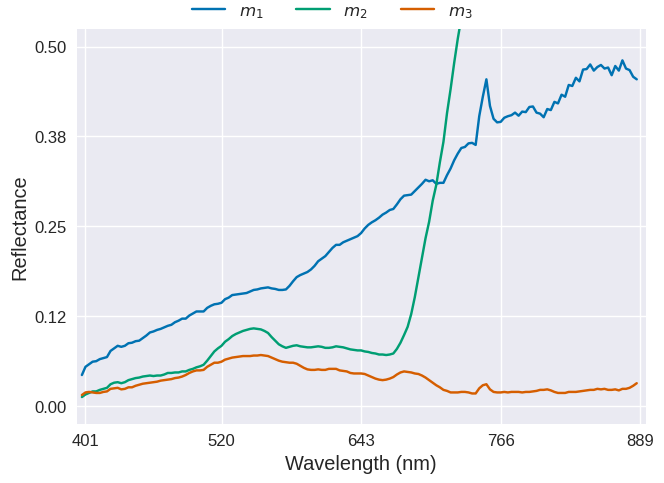

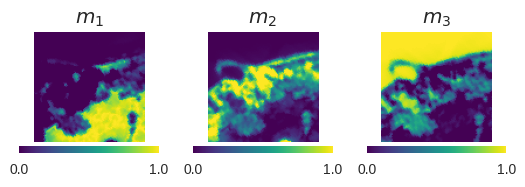

In [25]:
fig = plot_endmembers(dataset.endmembers(), np.array(dataset.wv), ticks_range=(0, .5), n_ticks=5)
plt.show(fig)

fig = show_abundance(dataset.abundance())
plt.show(fig)

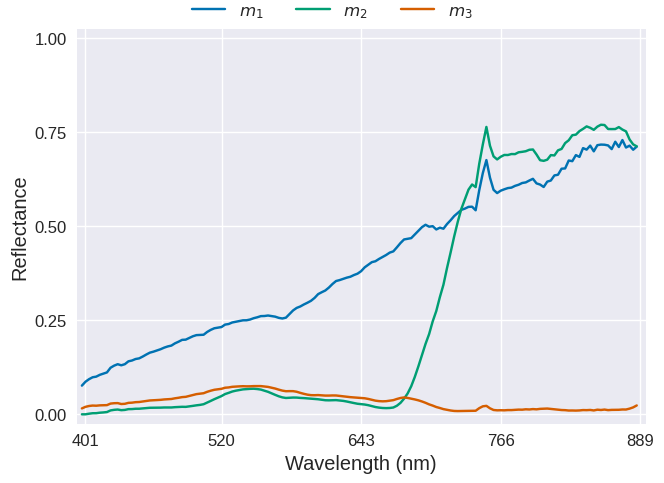

In [26]:
from HySpecLab.eea import VCA

n_endmembers = dataset.n_endmembers
   
vca = VCA(n_endmembers, snr_input=20, random_state=42)
vca.fit(dataset.X.numpy())
endmembers = torch.from_numpy(vca.endmembers()).float()
e_idx, sad_result = sort_endmember(endmembers, dataset.endmembers())

vca_endmember_init = endmembers[e_idx]
vca_logit_endmember_init = torch.log((vca_endmember_init + 1e-12) / ((1-vca_endmember_init) + 1e-12))

fig = plot_endmembers(vca_endmember_init, dataset.wv, ticks_range=(0, 1))
plt.show(fig)

endmember_init_method = 'vca'
endmember_init = vca_endmember_init
logit_endmember_init = vca_logit_endmember_init

In [27]:
from sklearn.model_selection import ParameterGrid
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing
import pandas as pd
from tqdm import tqdm

n_bands = dataset.n_bands
results = pd.DataFrame(columns=['sigma_sparsity', 'sparse_weight', 'mean_rmse_x', 'mean_rmse_a', 'mean_sad_m'])
for params in ParameterGrid(param_grid):
    sigma = params['sigma_sparsity']
    sparse_weight = params['sparse_weight']
    print('Sigma:', sigma, 'Sparse Weight:', sparse_weight)
    batch_rmse_x, batch_rmse_a, batch_sad_m = [], [], []

    for i in tqdm(range(5)):
        model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sigma_sparsity=sigma)
        train(model, n_endmembers, dataset, n_batchs=50, n_epochs=100, lr=1e-3, similarity_weight=1, sparse_weight=sparse_weight)
        rmse_x, rmse_a, sad_m = test(model, dataset)
        batch_rmse_x.append(rmse_x)
        batch_rmse_a.append(rmse_a)
        batch_sad_m.append(sad_m)

    mean_rmse_x = sum(batch_rmse_x) / len(batch_rmse_x)
    mean_rmse_a = sum(batch_rmse_a) / len(batch_rmse_a)
    mean_sad_m = sum(batch_sad_m) / len(batch_sad_m)
    
    results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)
    print('Mean RMSE X:', mean_rmse_x, 'Mean RMSE A:', mean_rmse_a, 'Mean SAD M:', mean_sad_m)

Sigma: 0.05 Sparse Weight: 0


100%|██████████| 5/5 [03:35<00:00, 43.00s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.01980752870440483 Mean RMSE A: 0.22842772901058198 Mean SAD M: 0.2001954585313797
Sigma: 0.05 Sparse Weight: 0.05


100%|██████████| 5/5 [03:26<00:00, 41.23s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.02085067518055439 Mean RMSE A: 0.22949598133563995 Mean SAD M: 0.17438217699527742
Sigma: 0.05 Sparse Weight: 0.1


100%|██████████| 5/5 [03:33<00:00, 42.79s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.020367790013551712 Mean RMSE A: 0.22977578938007354 Mean SAD M: 0.17169528603553771
Sigma: 0.05 Sparse Weight: 0.25


100%|██████████| 5/5 [03:31<00:00, 42.31s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.02002881057560444 Mean RMSE A: 0.2232471376657486 Mean SAD M: 0.1568006157875061
Sigma: 0.05 Sparse Weight: 0.5


100%|██████████| 5/5 [03:35<00:00, 43.03s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.030671438202261925 Mean RMSE A: 0.2330733835697174 Mean SAD M: 0.15688731372356415
Sigma: 0.05 Sparse Weight: 1


100%|██████████| 5/5 [03:28<00:00, 41.69s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.09841077253222466 Mean RMSE A: 0.4453322172164917 Mean SAD M: 0.23184288740158082
Sigma: 0.1 Sparse Weight: 0


100%|██████████| 5/5 [03:24<00:00, 40.81s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.020124757662415504 Mean RMSE A: 0.22721349000930785 Mean SAD M: 0.17245164513587952
Sigma: 0.1 Sparse Weight: 0.05


100%|██████████| 5/5 [03:24<00:00, 40.93s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.020139611884951593 Mean RMSE A: 0.22975710332393645 Mean SAD M: 0.1713077425956726
Sigma: 0.1 Sparse Weight: 0.1


100%|██████████| 5/5 [03:31<00:00, 42.27s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.021144963428378107 Mean RMSE A: 0.22490660846233368 Mean SAD M: 0.1667461186647415
Sigma: 0.1 Sparse Weight: 0.25


100%|██████████| 5/5 [03:36<00:00, 43.30s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.02052205801010132 Mean RMSE A: 0.22184837460517884 Mean SAD M: 0.1543550580739975
Sigma: 0.1 Sparse Weight: 0.5


100%|██████████| 5/5 [03:35<00:00, 43.04s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.03296933583915233 Mean RMSE A: 0.23280597031116484 Mean SAD M: 0.15226275622844695
Sigma: 0.1 Sparse Weight: 1


100%|██████████| 5/5 [03:32<00:00, 42.58s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.06149939000606537 Mean RMSE A: 0.42331611514091494 Mean SAD M: 0.22545359134674073
Sigma: 0.25 Sparse Weight: 0


100%|██████████| 5/5 [03:32<00:00, 42.42s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.020825615152716637 Mean RMSE A: 0.21860075294971465 Mean SAD M: 0.18178241550922394
Sigma: 0.25 Sparse Weight: 0.05


100%|██████████| 5/5 [03:31<00:00, 42.23s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.01967841647565365 Mean RMSE A: 0.22063231468200684 Mean SAD M: 0.17739999890327454
Sigma: 0.25 Sparse Weight: 0.1


100%|██████████| 5/5 [03:28<00:00, 41.74s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.02018975242972374 Mean RMSE A: 0.218913796544075 Mean SAD M: 0.16960691213607787
Sigma: 0.25 Sparse Weight: 0.25


100%|██████████| 5/5 [03:25<00:00, 41.10s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.02117415554821491 Mean RMSE A: 0.21715954542160035 Mean SAD M: 0.15143170952796936
Sigma: 0.25 Sparse Weight: 0.5


100%|██████████| 5/5 [03:25<00:00, 41.03s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.03120236098766327 Mean RMSE A: 0.22959792017936706 Mean SAD M: 0.1482599437236786
Sigma: 0.25 Sparse Weight: 1


100%|██████████| 5/5 [03:27<00:00, 41.44s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.05775628834962845 Mean RMSE A: 0.348101407289505 Mean SAD M: 0.18053882122039794
Sigma: 0.5 Sparse Weight: 0


100%|██████████| 5/5 [03:33<00:00, 42.77s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.018524231016635896 Mean RMSE A: 0.20264507532119752 Mean SAD M: 0.178451606631279
Sigma: 0.5 Sparse Weight: 0.05


100%|██████████| 5/5 [03:24<00:00, 40.91s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.01859772428870201 Mean RMSE A: 0.2088066190481186 Mean SAD M: 0.1783921718597412
Sigma: 0.5 Sparse Weight: 0.1


100%|██████████| 5/5 [03:37<00:00, 43.53s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.01968819834291935 Mean RMSE A: 0.2090085983276367 Mean SAD M: 0.1778679221868515
Sigma: 0.5 Sparse Weight: 0.25


100%|██████████| 5/5 [03:37<00:00, 43.48s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.025749996677041052 Mean RMSE A: 0.21713935434818268 Mean SAD M: 0.1759874552488327
Sigma: 0.5 Sparse Weight: 0.5


100%|██████████| 5/5 [03:35<00:00, 43.10s/it]
/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


Mean RMSE X: 0.03544132709503174 Mean RMSE A: 0.2547645092010498 Mean SAD M: 0.19395798146724702
Sigma: 0.5 Sparse Weight: 1


100%|██████████| 5/5 [03:29<00:00, 41.98s/it]

Mean RMSE X: 0.05990060716867447 Mean RMSE A: 0.28120208978652955 Mean SAD M: 0.1712729513645172



/tmp/ipykernel_5558/1847138408.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'sigma_sparsity': sigma, 'sparse_weight': sparse_weight, 'mean_rmse_x': mean_rmse_x, 'mean_rmse_a': mean_rmse_a, 'mean_sad_m': mean_sad_m}, ignore_index=True)


In [28]:
results

,sigma_sparsity,sparse_weight,mean_rmse_x,mean_rmse_a,mean_sad_m
0,0.05,0.00,0.019808,0.228428,0.200195
1,0.05,0.05,0.020851,0.229496,0.174382
2,0.05,0.10,0.020368,0.229776,0.171695
3,0.05,0.25,0.020029,0.223247,0.156801
4,0.05,0.50,0.030671,0.233073,0.156887
5,0.05,1.00,0.098411,0.445332,0.231843
6,0.10,0.00,0.020125,0.227213,0.172452
7,0.10,0.05,0.020140,0.229757,0.171308
8,0.10,0.10,0.021145,0.224907,0.166746
9,0.10,0.25,0.020522,0.221848,0.154355


In [30]:
csv_save_path = os.path.join(result_path, 'hyperparameters.csv')
results.to_csv(csv_save_path, index=False)

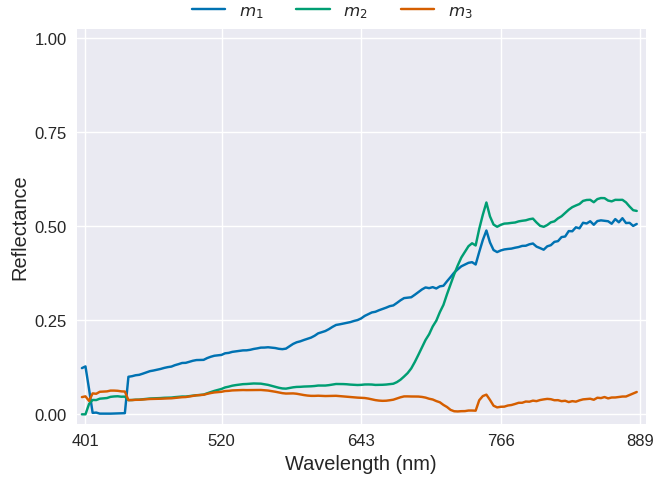

In [35]:
M_hat = sigmoid(model.ebk.detach().cpu()).numpy()

fig = plot_endmembers(M_hat, dataset.wv, ticks_range=(0, 1))
plt.show(fig)

In [ ]:
# test = model._sparse.detach().cpu().numpy().reshape(dataset.n_row, dataset.n_col)
test = model.sparse_gate.variational_parameter().detach().cpu().numpy().reshape(dataset.n_row, dataset.n_col)
test = np.log(test)
fig = plt.figure(figsize=(6,4))
plt.imshow(test.T, cmap='jet')
plt.grid(False)
# remove ticks
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.set_label(f'$\\log(\\tau)$', rotation=90, labelpad=8, fontsize='x-large')
# title to the colorbar
plt.show()

# fig.savefig(os.path.join(result_path, f'clhu/imgs/sparsity_estimation_{endmember_init_method}.pdf'), dpi=300, bbox_inches='tight')


In [ ]:
X_true = dataset.A @ dataset.endmembers()
X_hat = model(dataset.X).detach().cpu()
A_hat = torch.softmax(model.A.detach().cpu(), dim=1)
M_hat = sigmoid(model.ebk.detach().cpu())

real_M_hat = model(M_hat).detach()

import pandas as pd
df = pd.DataFrame(columns=['Method', 'RMSE_X', 'RMSE_A', 'SAD_M'])
df['Method'] = ['CLHU']
df['RMSE_X'] = [rmse(X_true, X_hat, dim=None).numpy()]
df['RMSE_A'] = [rmse(dataset.A, A_hat, dim=None).numpy()]

# sad_result = sad(M_hat, dataset.endmembers()).numpy()
sad_result = sad(real_M_hat, dataset.endmembers()).numpy()
df['SAD_M'] = np.diagonal(sad_result).mean()

# df.to_csv(os.path.join(result_path, 'clhu/metrics.csv'), index=False)
df

In [ ]:
# model.ebk = sigmoid(model.ebk)
x_test = sigmoid(model.ebk)
m = model.ebk.detach()
model.eval()
print(x_test.min(), x_test.max())
encoder, projection = model.encoder, model.projection
from torch.nn.functional import normalize, softmax

def __similarity(X: torch.Tensor, ebk, temperature=1e-2) -> torch.Tensor:
        '''
            Cosine similarity between input and endmember bank.

            Parameters
            ----------
                x: torch.Tensor, shape=(batch_size, n_bands)
                    input tensor.
                
                temperature: float, default=1e-1
                    temperature parameter for contrastive learning.
                
        '''
        bs, n_bands = X.shape
        X = normalize(X, dim=1)

        normalize_ebk = normalize(ebk.detach(), dim=1).expand(bs, -1, -1)
        cos = torch.bmm(X.view(bs, 1, n_bands), torch.transpose(normalize_ebk, 1, 2)).squeeze()
        # return (1 - torch.pow(cos, 2))/temperature
        # return (torch.pow(cos, 2))/temperature
        return torch.log(torch.pow(cos, 2))

# y = projection(encoder(x_test))
# print(softmax(__similarity(y, m, temperature=.1).detach(), dim=1))

test = model(x_test)

plt.plot(test[2].detach().numpy())
plt.plot(x_test[2].detach().numpy())
plt.show()

softmax(model.A)

# ...

In [ ]:
from torch import sigmoid
def test(model, dataset):
    X = dataset.X
    model.eval()
    model = model.cpu()
    
    X_true = dataset.A @ dataset.endmembers()
    with torch.no_grad():
        X_hat = model(dataset.X)
        A_hat = torch.softmax(model.A, dim=1)
        M_hat = sigmoid(model.ebk) 
    
    rmse_x = rmse(X_true, X_hat, dim=None).numpy()      
    rmse_a = rmse(dataset.A, A_hat, dim=None).numpy()
    sad_m = np.diagonal(sad(M_hat, dataset.endmembers()).numpy()).mean()
    return rmse_x.item(), rmse_a.item(), sad_m

In [ ]:
from utils import train 
from HySpecLab.unmixing import ContrastiveUnmixing

n_bands = dataset.n_bands

batch_rmse_x = []
batch_rmse_a = []
batch_sad_m = []
for i in range(10):
    model = ContrastiveUnmixing(n_bands, n_endmembers, endmember_init=logit_endmember_init, sigma_sparsity=.25)
    train(model, n_endmembers, dataset, n_batchs=100, n_epochs=100, lr=1e-3, similarity_weight=1, sparse_weight=.5)

    rmse_x, rmse_a, sad_m = test(model, dataset)
    batch_rmse_x.append(rmse_x)
    batch_rmse_a.append(rmse_a)
    batch_sad_m.append(sad_m)

    print(rmse_x, rmse_a, sad_m)

In [ ]:
# generate dataframe
import pandas as pd
df = pd.DataFrame(columns=['RMSE_X', 'RMSE_A', 'SAD_M'])
df['RMSE_X'] = batch_rmse_x
df['RMSE_A'] = batch_rmse_a
df['SAD_M'] = batch_sad_m

# extract mean and std
df['RMSE_X'].mean(), df['RMSE_X'].std(), df['RMSE_A'].mean(), df['RMSE_A'].std(), df['SAD_M'].mean(), df['SAD_M'].std()

In [ ]:
df.to_csv(os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method)), index=False)

In [ ]:
os.path.join(result_path, 'clhu/metrics_{}_batch.csv'.format(endmember_init_method))

In [ ]:
plt.plot(sigmoid(model.ebk).T.detach().cpu().numpy())
plt.show()

In [ ]:
plt.plot(test.T.detach().cpu().numpy())
plt.show()

sad_m = np.diagonal(sad(test, dataset.endmembers()).detach().numpy()).mean()
sad_m

In [ ]:
from torch.nn.functional import normalize   
M = logit_endmember_init
M_norm = normalize(M, dim=1)

sim_matrix = torch.mm(M_norm, M_norm.T) / .1

logit = torch.log((sim_matrix).softmax(dim=1))
lo2 = (sim_matrix).log_softmax(dim=1)

sim_matrix, torch.isclose(logit, lo2)


In [ ]:
M_2 = M.clone()

M_2[0] = M_2[2]
M_norm = normalize(M_2, dim=1)

sim_matrix = torch.mm(M_norm, M_norm.T) / .1

logit = torch.log((sim_matrix).softmax(dim=1))
lo2 = (sim_matrix).log_softmax(dim=1)

sim_matrix, torch.isclose(logit, lo2)

# (sim_matrix).softmax(dim=1)

In [ ]:
import torch
from torch.nn.functional import dropout2d

X = torch.randn(1, 3, 3, 3)
hat_X = dropout2d(X, p=.5, training=True)